# Overview

This notebook runs through the week 1 task from the MLX apprenticeship, namely building a language prediction model, and deploying it via Gradio and Tmux. 

# Imports

In [1]:
import pandas as pd
import torch

# Solution Structure

- [Proposed dataset](https://huggingface.co/datasets/iix/Parquet_FIles)
- Prep and tokenize dataset for word2vec model
- Create word2vec model
- Train word2vec model to get embedding matrix
- Prep and tokenize dataset for MLP classification model
- Create MLP classification model
- Train MLP classification model
- Launch persistent app via uvicorn/screen/tmux

# Prepare Dataset

In [2]:
!wget https://huggingface.co/datasets/iix/Parquet_FIles/resolve/main/Flores7Lang.parquet -O Flores7Lang.parquet

--2024-02-02 15:37:04--  https://huggingface.co/datasets/iix/Parquet_FIles/resolve/main/Flores7Lang.parquet
Resolving huggingface.co (huggingface.co)... 3.162.140.63, 3.162.140.75, 3.162.140.4, ...
Connecting to huggingface.co (huggingface.co)|3.162.140.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/fc/9a/fc9a918f6fbc19623c4d012eb54560ce331bef7d7208a8ec162d38c5b4a37971/ef205c73926e8ca0f0cb29276761c4716790d1e15498b0da361063c5348f5e9d?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27Flores7Lang.parquet%3B+filename%3D%22Flores7Lang.parquet%22%3B&Expires=1707147424&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNzE0NzQyNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9mYy85YS9mYzlhOTE4ZjZmYmMxOTYyM2M0ZDAxMmViNTQ1NjBjZTMzMWJlZjdkNzIwOGE4ZWMxNjJkMzhjNWI0YTM3OTcxL2VmMjA1YzczOTI2ZThjYTBmMGNiMjkyNzY3NjFjNDcxNjc5MGQxZTE1NDk4YjBkYTM2MTA2M2M1MzQ4

In [3]:
data = pd.read_parquet("Flores7Lang.parquet")


In [4]:
# Convert dataframe from wide to long format
# Set value_vars to all columns, and no id_vars.
# This creates a new row for every cell in the dataframe, labelled by the column name.
data_long_format = data.melt(value_vars=data.columns)

In [5]:
# Dump all the translations into one unlabelled list
# The W2V model doesn't need labelled data, that will come in the classification MLP
w2v_corpus = data_long_format['value'].tolist()

In [6]:
# Initialise our W2V torch dataset class, with this corpus
from lang_class_datasets import W2VData
w2v_dataset = W2VData(w2v_corpus)

In [7]:
# Examine some entries, to sanity check
print("word2vec:corpus[0]", w2v_corpus[0])
print("word2vec:ds[0]", w2v_dataset[0])

word2vec:corpus[0] Am Montag haben die Wisenschaftler der Stanford University School of Medicine die Erfindung eines neuen Diagnosetools bekanntgegeben, mit dem Zellen nach ihrem Typ sortiert werden können: ein winziger, ausdruckbarer Chip, der für jeweils etwa einen US-Cent mit Standard-Tintenstrahldruckern hergestellt werden kann.

word2vec:ds[0] (tensor([ 3825, 11213, 17031,    81]), tensor(1675))


# Store Offline Tokenised Vocab

In [8]:
from tokenizer import Tokenizer
data = pd.read_parquet("./Flores7Lang.parquet")
long_format = data.melt(value_vars=data.columns)
corpus = long_format["value"].tolist()
tknz = Tokenizer(corpus)
tknz.save_vocab("./vocab.txt")
tknz.load_vocab("./vocab.txt")
print(len(tknz.vocab))
print(tknz.vocab[90:100])


26679
['manadas', 'vorsichtig', 'najbaro', 'connection', 'kullanılmıştır', 'gravità', 'sabbatico', 'costituzione', 'descarga', 'elleri']


# Create DataLoader, CBOW Model, Loss Function and Optimizer

In [19]:
from model import CBOW
w2v_dataloader = torch.utils.data.DataLoader(w2v_dataset, batch_size=1024, shuffle=True)
# CBOW takes (vocab_size, embedding_dim) as inputs
cbow = CBOW(len(w2v_dataset.tokenizer.vocab), 50)
# Use negative log likelihood loss
# In the CBOW task, we're examining the likelihood over the vocab set, in comparison to a ground truth (the missing word)
# This is equivalent to a classification task. Guess the correct class amongst a set of classes
# Hence, we use negative log likelihood
loss_function = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=0.001)

# Run Training Loop for W2V Model (Logging via Weights and Biases)

# Adapt to use MLFlow too

2024/02/02 16:14:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/02/02 16:14:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2024/02/02 16:14:22 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
Epoch 1/3: 100%|██████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.30batch/s]


Epoch 1/10, Loss: 2221.4974603652954


Epoch 2/3: 100%|██████████████████████████████████████████████████████████████████████████| 205/205 [00:47<00:00,  4.34batch/s]


Epoch 2/10, Loss: 2220.161244392395


Epoch 3/3: 100%|██████████████████████████████████████████████████████████████████████████| 205/205 [00:45<00:00,  4.54batch/s]


Epoch 3/10, Loss: 2218.9234552383423


/Users/shaheen.ahmed-chowd/opt/anaconda3/envs/MLX_workshop_2_feb_mlflow/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/shaheen.ahmed-chowd/opt/anaconda3/envs/MLX_workshop_2_feb_mlflow/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/02/02 16:16:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/02/02 16:16:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system met

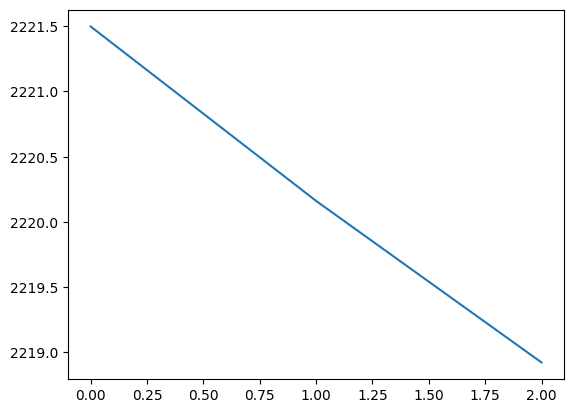

In [20]:
import tqdm
import mlflow
import matplotlib.pyplot as plt
# Setting tracking uri
mlflow.set_tracking_uri('http://localhost:5000')


# Setting the experiment
mlflow.set_experiment('lang_classification_test')

# Enabling System Metrics
mlflow.enable_system_metrics_logging()

# Start MLflow run
with mlflow.start_run():
    mlflow.pytorch.autolog()
    n_epochs = 3
    total_loss_hist = []
    for epoch in range(n_epochs):
        total_loss = 0
        for context, target in tqdm.tqdm(w2v_dataloader, desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch"):
            # We don't want to accumulate gradients over batches, so zero them at the start of each batch's training loop
            optimizer.zero_grad()
            # PyTorch calls .forward() automatically, when we pass data to it
            log_probs = cbow(context)
            # Pass ground truth (target) and model outputs (log_probs) to loss function
            loss = loss_function(log_probs, target)
            # Perform backprop step (calc gradients of loss function wrt model params)
            loss.backward()
            # Change the parameter weights, according to selected optimizer
            optimizer.step()
            # Add up loss for printing purposes
            total_loss += loss.item()
            mlflow.log_metric("loss", loss)
            mlflow.log_metric("total_loss", total_loss)
            mlflow.log_param('n_epochs', n_epochs)
            mlflow.set_tag("run_type", "test")
        total_loss_hist.append(total_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss}")
        torch.save(cbow.state_dict(), f"./cbow_epoch_{epoch+1}.pt")
    plt.plot(total_loss_hist)
    plt.savefig('total_loss_history.png')
    mlflow.log_artifact("total_loss_history.png")
    mlflow.pytorch.log_model(cbow, "test_cbow_model")




In [22]:
result = mlflow.register_model(
    "runs:/32f94ebc42b44a0e973f59f66c66d72e/model",
    "test_lang_classification_model"
)

Registered model 'test_lang_classification_model' already exists. Creating a new version of this model...
2024/02/02 16:21:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: test_lang_classification_model, version 1
Created version '1' of model 'test_lang_classification_model'.


In [24]:
model_uri = "models:/test_lang_classification_model/1"
model_from_mlflow = mlflow.pyfunc.load_model(model_uri)

MlflowException: The following failures occurred while downloading one or more artifacts from http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/912598759279177923/32f94ebc42b44a0e973f59f66c66d72e/artifacts/model:
##### File  #####
API request to http://localhost:5000/api/2.0/mlflow-artifacts/artifacts/912598759279177923/32f94ebc42b44a0e973f59f66c66d72e/artifacts/model/ failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow-artifacts/artifacts/912598759279177923/32f94ebc42b44a0e973f59f66c66d72e/artifacts/model/ (Caused by ResponseError('too many 500 error responses'))

# Prepare Data and DataLoader for Classification MLP Layer

In [37]:
from lang_class_datasets import LangData
# Need data in format (sentence, language_id, language)
data = pd.read_parquet("./Flores7Lang.parquet")
lang_classification_ds = LangData(data)
lang_classification_dl = torch.utils.data.DataLoader(lang_classification_ds, batch_size=1, shuffle=True)

# Create Classification Model (initialized with W2V weights)

In [38]:
from model import Language
vocab_size = len(lang_classification_ds.tknz.vocab)
state_dict = torch.load(f'cbow_epoch_{n_epochs}.pt')
pre_trained_cbow = CBOW(len(w2v_dataset.tokenizer.vocab), 50)
pre_trained_cbow.load_state_dict(state_dict)
classification_model = Language(pre_trained_cbow.embeddings.weight.data, 7)

# Create Loss Function and Optimizer

In [39]:
# Classification --> use cross entropy
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classification_model.parameters(), lr=0.001)

# Run Training Loop for Classification Model

In [45]:
n_epochs_classification = 3
for epoch in range(n_epochs_classification):
    for sentence, target, _ in tqdm.tqdm(lang_classification_dl, unit='batch'):
        optimizer.zero_grad()
        log_probs = classification_model(sentence)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        # print(f"Epoch {epoch+1}/5, Loss: {loss.item()}")
    torch.save(classification_model.state_dict(), f"./classification_model_epoch_{n_epochs_classification+1}.pt")

100%|████████████████████████████████| 14063/14063 [00:11<00:00, 1252.94batch/s]


# Load pre-trained model

In [32]:
from model import Language
from tokenizer import Tokenizer
# Load pretrained classification model
state_dict_classification = torch.load(f'classification_model_epoch_4.pt')
# Initialise tokenizer with vocab
tokenizer = (Tokenizer()).load_vocab("./vocab.txt")
# Use tokenizer vocab size to initialise language classification model
classification_model = Language(torch.rand(len(tokenizer.vocab), 50), 7)
print (pre_trained_cbow.embeddings.weight.data.shape)
# Load pre-trained weights into classification model
classification_model.load_state_dict(state_dict_classification)
# Set language ordering
langs = ["German", "Esperanto", "French", "Italian", "Spanish", "Turkish", "English"]
classification_model.eval()


torch.Size([26679, 50])


<All keys matched successfully>

# Predict language of dummy text

In [34]:
text = 'the cat sat on the hat'
tokens = tokenizer.encode(text)
tokens = torch.tensor(tokens, dtype=torch.long).unsqueeze(0)
# Pass tokens through forward method of model
predictions = classification_model(tokens)
# Softmax to get probability distribution
predictions_softmaxed = torch.nn.functional.softmax(predictions, dim=1)
predictions_softmaxed = predictions_softmaxed.squeeze(0).tolist()

result = [{"class": class_name, "value": value} for class_name, value in zip(langs, predictions_softmaxed)]
result

[{'class': 'German', 'value': 0.0076903305016458035},
 {'class': 'Esperanto', 'value': 0.34975698590278625},
 {'class': 'French', 'value': 0.1005527600646019},
 {'class': 'Italian', 'value': 0.020299967378377914},
 {'class': 'Spanish', 'value': 0.44341129064559937},
 {'class': 'Turkish', 'value': 0.060587987303733826},
 {'class': 'English', 'value': 0.01770068146288395}]